# Recommender System by collaborative filtering

## Team 1

- EDGAR BAZO PEREZ
- CARLOS GEOVANY PEREZ VELAZQUEZ
- ITA-ANDEHUI SANTIAGO CASTILLEJOS

This proyect objective is to implement collaborative filtering recommender system by matrix factorization algorithm. The problem consist in try to solve how Netflix is able to determine what content you’re likely to enjoy on its platform.

We will test and train the model with both dummy and Netflix movies dataset.

### Collaborative Filtering
As there are many aproaches to this problem, we will be focusing on Collaborative filtering. **Collaborative filtering does not concern itself with non-abstract features of an item, but rather uses the wisdom of the crowd to generate recommendations.** This methodology core idea is to predict how well a user will like an item that he has not rated given a set of historical preference judgments for a community of users. So we will have a user as an individual who provides movies ratings to the system and movies rated by the users.

The input for the Collaborative Filtering prediction algorithm will be a matrix of users’ ratings on movies, the **ratings matrix.**



### Matrix Factorization

Matrix factorization is a embedding model. Given the feedback matrix $D \in R^{axi}$ , where $a$ is the number of users and $i$ is the number of movies:

$$
\begin{bmatrix}
U1M1 & U1M2 \\
U2M1 & U2M2 \\
U3M1 & U3M2
\end{bmatrix}
x
\begin{bmatrix}
M1R1 & M1R2 & M1R3 \\
M2R1 & M2R2 & M2R3
\end{bmatrix}
=
\begin{bmatrix}
U1R1 & U1R2 & U1R3 \\
U2R1 & U2R2 & U2R3\\
U3R1 & U3R2 & U3R3
\end{bmatrix}
$$


- A user embedding matrix , where row i is the embedding for user i.
- An movie embedding matrix , where row j is the embedding for movie j.

The embeddings are learned such that the product $UV^T$ is a good approximation of the recommendation matrix $D$. As a result, matrix factorization finds latent structure in the data, assuming that observations lie close to a low-dimensional subspace.

## Objective Function

$$D = {(a,i) |  Y_{ai} \text{ es dada}}$$


$$J(X) = \frac{1}{2} \sum_{(a,i)\in D} (Y_{ai} - [UV^T]ai)^2 + \frac{\lambda}{2} \sum_{a=1}^n\sum_{j=1}^k U_{aj^2}$$


The core idea is to create parameters and iteratively update them to minimize some cost function, like in gradient descent: Minimizr our objective function.

- Start randomly V and U
- Fix U and solve for V
- Fix V and solve for U
- Find loss and repeat until converge(find local minimum)

In [364]:
import re
import numpy as np
import pandas as pd
import plotly.express as px


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split

from recommender import matrix_factorization, find_best #our very own recommender system

np.random.seed(seed=1983)
pd.set_option("display.max_columns", 10)

## Netflix ratings DB EDA

In [22]:
ratings = pd.read_csv("data/ratings_small.csv")

In [23]:
##Columns not needed
ratings.drop('timestamp', axis=1, inplace=True)

In [24]:
## Order by movieId
ratings.sort_values('movieId', inplace=True)

In [25]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 9713 to 80823
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.1 MB


In [26]:
ratings.head()

,userId,movieId,rating
9713,68,1,4.0
35933,261,1,1.5
52631,383,1,5.0
35983,262,1,2.5
12038,77,1,4.0


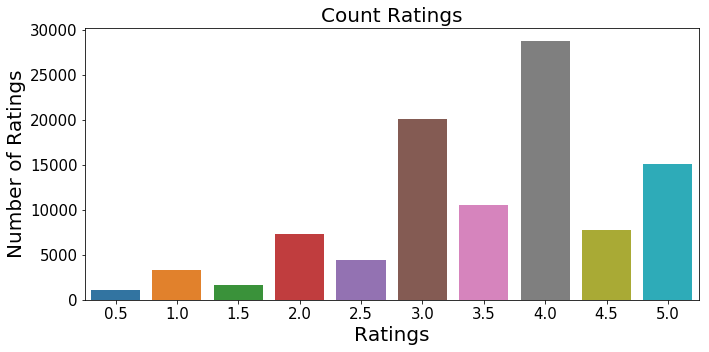

In [27]:
plt.figure(figsize = (11, 5))
sns.countplot(x="rating", data=ratings)
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [28]:
## Group by userid and count the numbers of movies rated by that user
ratings.groupby("userId")["rating"].count().sort_values(ascending = False).head()

userId
547    2391
564    1868
624    1735
15     1700
73     1610
Name: rating, dtype: int64

In [29]:
## Group by movies and count the number of users rated that movie
ratings.groupby("movieId")["rating"].count().sort_values(ascending = False).head()

movieId
356    341
296    324
318    311
593    304
260    291
Name: rating, dtype: int64

In [30]:
## set userId as index
ratings = ratings.set_index('userId').sort_index(axis = 0)

In [31]:
ratings

,movieId,rating
userId,,
1,2455,2.5
1,1287,2.0
1,2968,1.0
1,1339,3.5
1,1172,4.0
...,...,...
671,1266,4.0
671,1197,3.5
671,4022,3.5


In [32]:
## pivot df to get the matrix Yai
ratings = ratings.pivot(index=ratings.index, columns='movieId')['rating']

In [33]:
## replace NAN with movie mean
ratings = ratings.fillna(ratings.mean())
## replace NAN with zero
#ratings = ratings.fillna(0)

In [34]:
ratings.head(5)

movieId,1,2,3,4,5,...,161944,162376,162542,162672,163949
userId,,,,,,,,,,,
1,3.87247,3.401869,3.161017,2.384615,3.267857,...,5.0,4.5,5.0,3.0,5.0
2,3.87247,3.401869,3.161017,2.384615,3.267857,...,5.0,4.5,5.0,3.0,5.0
3,3.87247,3.401869,3.161017,2.384615,3.267857,...,5.0,4.5,5.0,3.0,5.0
4,3.87247,3.401869,3.161017,2.384615,3.267857,...,5.0,4.5,5.0,3.0,5.0
5,3.87247,3.401869,4.000000,2.384615,3.267857,...,5.0,4.5,5.0,3.0,5.0


### Netfilx movies DB EDA

In [374]:
movies_data = pd.read_csv("data/movies_metadata.csv", usecols=['genres','id','title','original_language','release_date'])

In [375]:
## Remove id and name from string
movies_data['genres'].replace({'id': ''}, inplace=True, regex=True)
movies_data['genres'].replace({'name': ''}, inplace=True, regex=True)
movies_data['genres'].replace({'\d+': ''}, inplace=True, regex=True)
## Remove special characters
movies_data['genres'].replace({'\W+': ' '}, inplace=True, regex=True)
## Remove leading and trailing blanks
movies_data['genres'] = movies_data['genres'].str.strip()
## Formatiing the string
movies_data['genres'].replace({' ': ', '}, inplace=True, regex=True)
## split in to a list
movies_data['genres'] = [x.strip('()').split(',') for x in movies_data['genres']]

In [376]:
## Cleaning id column
movies_data.drop(movies_data[movies_data['id'].str.contains("-")].index, inplace = True)
movies_data['id'] = movies_data['id'].astype('int64')
## Rename id column to movieId
movies_data.rename(columns={'id': 'movieId'}, inplace=True)

In [377]:
movies_data.head()

,genres,movieId,original_language,release_date,title
0,"[Animation, Comedy, Family]",862,en,1995-10-30,Toy Story
1,"[Adventure, Fantasy, Family]",8844,en,1995-12-15,Jumanji
2,"[Romance, Comedy]",15602,en,1995-12-22,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,en,1995-12-22,Waiting to Exhale
4,[Comedy],11862,en,1995-02-10,Father of the Bride Part II


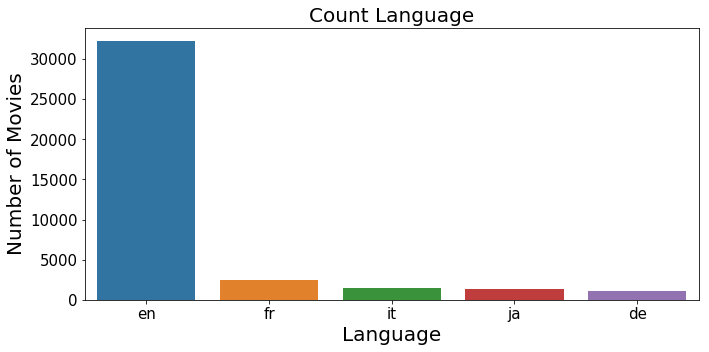

In [378]:
## Plot movies by original language
plt.figure(figsize = (11, 5))
sns.countplot(data=movies_data,
              order=movies_data.original_language.value_counts().iloc[:5].index,
              x='original_language')
plt.tick_params(labelsize = 15)
plt.title("Count Language", fontsize = 20)
plt.xlabel("Language", fontsize = 20)
plt.ylabel("Number of Movies", fontsize = 20)
plt.show()

## Movies Time series

In [379]:
## Counter for movies date
movies_data['count'] = 1

In [380]:
## Transform column to date type
movies_data['release_date'] =  pd.to_datetime(movies_data['release_date'], format='%Y-%m-%d')

In [381]:
movies_data['release_date'].min(), movies_data['release_date'].max()

(Timestamp('1874-12-09 00:00:00'), Timestamp('2020-12-16 00:00:00'))

In [382]:
## Group by date and count movies
daily_frame = movies_data.groupby('release_date')['count'].sum().reset_index()
daily_frame = daily_frame.set_index('release_date')
daily_frame.index = pd.to_datetime(daily_frame.index)

In [383]:
## Sum the counts of movies by year
y = daily_frame['count'].resample('MS').sum()

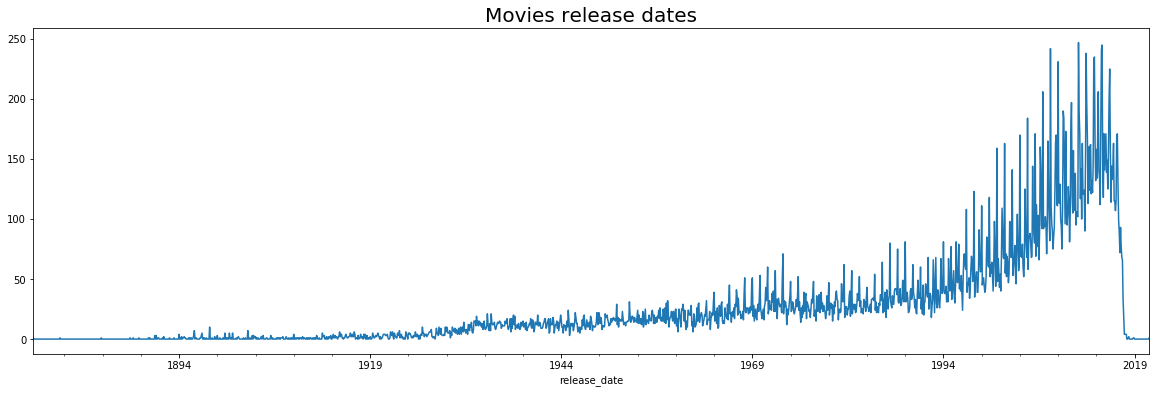

In [390]:
y.plot(figsize=(20, 6))
plt.title("Movies release dates", fontsize = 20)
plt.show()

## Test and train on a Dummy dataset

In [3]:
## Dummy dataset
a = pd.DataFrame([

     [1,5,3,0,1],

     [2,4,0,0,1],

     [3,1,1,0,5],

     [4,1,0,0,4],

     [5,0,1,5,4],
    
     [6,2,1,3,0],

    ]).set_index(0)

a.index.names = ['userId']
a.columns.names = ['movieId']

### Train with sklear KFold library

In [4]:
kfs = KFold(n_splits=3)

In [5]:
## Train with different learning rates and K numbers
m_s=[]
for train, _ in kfs.split(a,None):
    df = pd.DataFrame(train)
    print(f"TRAIN: {train}")
    m_s.append(find_best(df,max_Ks=50, iterations=100)) 

TRAIN: [2 3 4 5]
K: 10	 | Learning_rate: 0.001	 | MSE:15.071774580026862
K: 10	 | Learning_rate: 0.01	 | MSE:2.1935173516309603
K: 10	 | Learning_rate: 0.1	 | MSE:1.048841605777777
K: 10	 | Learning_rate: 1	 | MSE:1.0004228488678764
K: 20	 | Learning_rate: 0.001	 | MSE:9.742491280681216
K: 20	 | Learning_rate: 0.01	 | MSE:3.3128476160047637
K: 20	 | Learning_rate: 0.1	 | MSE:1.1135070267130305
K: 20	 | Learning_rate: 1	 | MSE:1.0001488119597617
K: 30	 | Learning_rate: 0.001	 | MSE:50.043668589204515
K: 30	 | Learning_rate: 0.01	 | MSE:5.8665436574547485
K: 30	 | Learning_rate: 0.1	 | MSE:1.3855595878742568
K: 30	 | Learning_rate: 1	 | MSE:1.0001700971341196
K: 40	 | Learning_rate: 0.001	 | MSE:98.72441027437411
K: 40	 | Learning_rate: 0.01	 | MSE:12.077928617612175
K: 40	 | Learning_rate: 0.1	 | MSE:1.5188445211818773
K: 40	 | Learning_rate: 1	 | MSE:1.0000225465023582
K: 50	 | Learning_rate: 0.001	 | MSE:139.654434326975
K: 50	 | Learning_rate: 0.01	 | MSE:21.651910763520878
K: 50	 | 

In [6]:
## Finding best K and learning rate
best_folded = []
b = float(10e5)
for df in m_s:
    mini = df.loc[df.MSE.idxmin()]
    if (mini[2] < b):
        b = mini[2]
        best_folded.append(mini)
best_folded

[K                2.000000
 Learning_rate    1.000000
 MSE              0.991765
 Name: 7, dtype: float64]

### Training with the full dummy dataset

In [7]:
## Train with different learning rates and K numbers
m = find_best(a,max_Ks=50,iterations=100)

K: 10	 | Learning_rate: 0.001	 | MSE:78.1214260111823
K: 10	 | Learning_rate: 0.01	 | MSE:86.28113862400143
K: 10	 | Learning_rate: 0.1	 | MSE:49.73856326566307
K: 10	 | Learning_rate: 1	 | MSE:13.962388591051903
K: 20	 | Learning_rate: 0.001	 | MSE:249.84306045495265
K: 20	 | Learning_rate: 0.01	 | MSE:117.8982038188301
K: 20	 | Learning_rate: 0.1	 | MSE:41.84450340611182
K: 20	 | Learning_rate: 1	 | MSE:8.703282239690118
K: 30	 | Learning_rate: 0.001	 | MSE:521.5249383280899
K: 30	 | Learning_rate: 0.01	 | MSE:149.50053809355327
K: 30	 | Learning_rate: 0.1	 | MSE:39.73635794264919
K: 30	 | Learning_rate: 1	 | MSE:8.443336123102648
K: 40	 | Learning_rate: 0.001	 | MSE:726.442452115472
K: 40	 | Learning_rate: 0.01	 | MSE:200.15325859692388
K: 40	 | Learning_rate: 0.1	 | MSE:34.70587605486276
K: 40	 | Learning_rate: 1	 | MSE:6.830143483537256
K: 50	 | Learning_rate: 0.001	 | MSE:1427.1901196048689
K: 50	 | Learning_rate: 0.01	 | MSE:247.9578191086278
K: 50	 | Learning_rate: 0.1	 | MSE:4

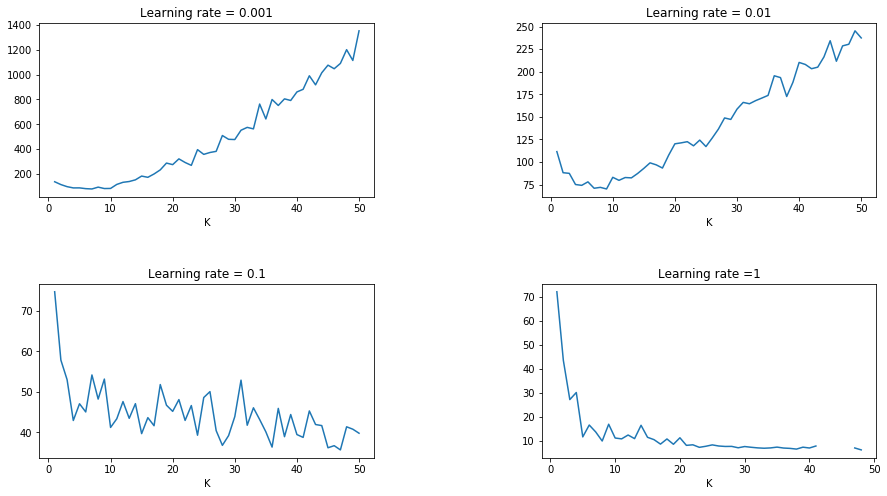

In [45]:
## Get minimum by Learning rate

## plot best k with bets learning rate
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

m[m['Learning_rate']==0.001].plot(x="K", y="MSE", ax=axes[0,0], legend=False)
axes[0, 0].set_title('Learning rate = 0.001')
m[m['Learning_rate']==0.01].plot(x="K", y="MSE", ax=axes[0,1], legend=False)
axes[0, 1].set_title('Learning rate = 0.01')
m[m['Learning_rate']==0.1].plot(x="K", y="MSE", ax=axes[1,0], legend=False)
axes[1, 0].set_title('Learning rate = 0.1')
m[m['Learning_rate']==1].plot(x="K", y="MSE", ax=axes[1,1], legend=False,)
axes[1, 1].set_title('Learning rate =1')
plt.show()

In [9]:
## Finding best K and learning rate
best_ = m.loc[m.MSE.idxmin()]
best_

K                47.000000
Learning_rate     1.000000
MSE               6.743231
Name: 187, dtype: float64

### Fit the model with best parameters

In [14]:
## Best matrix with best k
K = int(best_[0])
r = matrix_factorization(a,K)
## Train the model, default iterations is 2
learning_rate = float(best_[1])
r.fit(learning_rate,iterations=1000)

In [15]:
## Increasing iterations improves over previous best MSE but not significantly
min(r.mse)

5.999999999999976

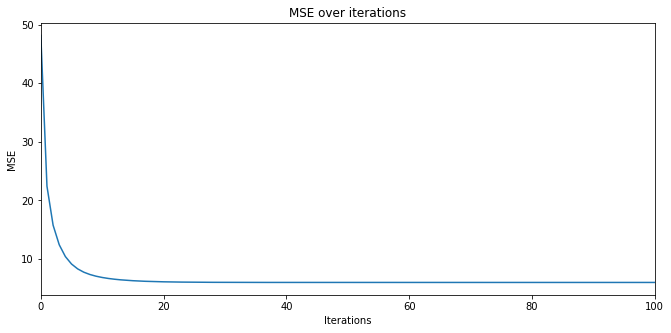

In [19]:
## Plot MSE over iterations
plt.figure(figsize=(11, 5))
plt.plot(r.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.xlim(0,100)
plt.title('MSE over iterations')
plt.show()

In [20]:
## Get the Predicted matrix
r.matrix

array([[5.5, 3.5, 0.5, 1.5],
       [4.5, 0.5, 0.5, 1.5],
       [1.5, 1.5, 0.5, 5.5],
       [1.5, 0.5, 0.5, 4.5],
       [0.5, 1.5, 5.5, 4.5],
       [2.5, 1.5, 3.5, 0.5]])

In [21]:
## Top 5 movies to recommend
r.top_recommends(1)

,movieId,rating,title
0,2,4.0,Ariel
1,3,0.0,Shadows in Paradise


# Netflix movies small DB

In [29]:
## Split dataset in train and test
train, test = train_test_split(ratings, test_size = 0.2)

### Train with sklear KFold library

In [30]:
## fold train dataset
kf = KFold(n_splits=3)

In [31]:
## Find best with folded training data
mse_s=[]
for train, _ in kf.split(train, None):
    df = pd.DataFrame(train)
    print(f"TRAIN: {len(train)} users")
    mse_s.append(find_best(df,max_Ks=10, iterations=5))

TRAIN: 357
K: 10	 | Learning_rate: 0.001	 | MSE:47456545.84381609
K: 10	 | Learning_rate: 0.01	 | MSE:14780450.528670654
K: 10	 | Learning_rate: 0.1	 | MSE:nan
K: 10	 | Learning_rate: 1	 | MSE:nan
TRAIN: 357
K: 10	 | Learning_rate: 0.001	 | MSE:36747419.45577236
K: 10	 | Learning_rate: 0.01	 | MSE:12140348.947856415
K: 10	 | Learning_rate: 0.1	 | MSE:155952.54175402687
K: 10	 | Learning_rate: 1	 | MSE:nan
TRAIN: 358
K: 10	 | Learning_rate: 0.001	 | MSE:14594952.097716218
K: 10	 | Learning_rate: 0.01	 | MSE:5958415.85919186
K: 10	 | Learning_rate: 0.1	 | MSE:323751.3246159377
K: 10	 | Learning_rate: 1	 | MSE:nan


In [32]:
best = []
b = float(10e5)
for df in mse_s:
    mini = df.loc[df.MSE.idxmin()]
    if (mini[2] < b):
        b = mini[2]
        best.append(mini)      
best

[K                    10.000000
 Learning_rate         0.100000
 MSE              155952.541754
 Name: 38, dtype: float64,
 K                    9.000000
 Learning_rate        0.100000
 MSE              74405.672036
 Name: 34, dtype: float64]

In [35]:
## Find best with full training data and folded best
mse = find_best(ratings,max_Ks=9,learning_rate=[0.1],iterations=10)

K: 1	 | Learning_rate: 0.1	 | MSE:28962111.001983564
K: 2	 | Learning_rate: 0.1	 | MSE:17824487.02727867
K: 3	 | Learning_rate: 0.1	 | MSE:12067357.535394998
K: 4	 | Learning_rate: 0.1	 | MSE:8560831.67812344
K: 5	 | Learning_rate: 0.1	 | MSE:6470689.568020732
K: 6	 | Learning_rate: 0.1	 | MSE:5049923.082067425
K: 7	 | Learning_rate: 0.1	 | MSE:4145209.191971612
K: 8	 | Learning_rate: 0.1	 | MSE:3491115.285465029
K: 9	 | Learning_rate: 0.1	 | MSE:3156870.462840118


<Figure size 792x360 with 0 Axes>

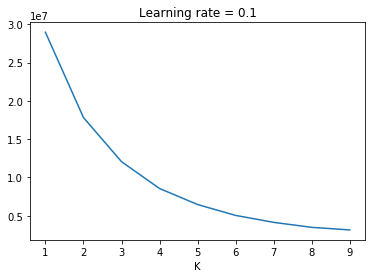

In [40]:
## Get minimum by Learning rate

## plot best k with bets learning rate
plt.figure(figsize=(11, 5))
mse.plot(x="K", y="MSE", legend=False)
plt.title('Learning rate = 0.1')
plt.show()

### Fit the model with best parameters

In [326]:
## Best matrix with best k
K = 9
recomm = matrix_factorization(ratings,K)
## Train the model, default iterations is 2
learning_rate = 0.1
recomm.fit(learning_rate,iterations=20)

KeyboardInterrupt: 

In [325]:
recomm.mse

[78.24152126224337,
 75.36719645398507,
 72.92234693168741,
 70.81078596905115,
 68.9579256831754,
 67.30633695460206,
 65.8120845244082,
 64.44172683626573,
 63.169898463695844,
 61.97739485130134,
 60.84967838027471,
 59.775728219211835,
 58.74716407898533,
 57.75758400148336,
 56.80206686835575,
 55.87680020752293,
 54.9788024841908,
 54.10571619383283,
 53.255653780247215,
 52.42708285589541]

In [ ]:
## Plot MSE over iterations
plt.figure(figsize=(11, 5))
plt.plot(recomm.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE over iterations')
plt.show()

## Recommendation Matrix

In [ ]:
## Get the Predicted matrix
recomm.matrix

## Geting recomendations

In [ ]:
## Top 5 movies to recommend
recomm.top_recommends(1)

### References

- [Sistemas de recomendación. Marmol Yahya, Juan Salvador](https://github.com/salvadormarmol/machine-learning-ms-2020/blob/master/no_supervisado/sistemas_de_recomendacion/Aprendizaje%20de%20m%C3%A1quina%20-%20Sistemas%20de%20recomendaci%C3%B3n.pdf)
- [Collaborative Filtering. Brusilovsky, Peter](https://pitt.edu/~peterb/2480-122/CollaborativeFiltering.pdf)
- [Matrix Factorization. Google developers](https://developers.google.com/machine-learning/recommendation/collaborative/matrix)
- [Python: Implementing Matrix Factorization from Scratch!. Moore, Jacob](https://towardsdatascience.com/recommender-systems-in-python-from-scratch-643c8fc4f704)